In [179]:
Dutch = 'https://www.gutenberg.org/cache/epub/39181/pg39181-images.html'
English = "https://www.gutenberg.org/cache/epub/1004/pg1004-images.html"
Finnish = "https://www.gutenberg.org/cache/epub/12546/pg12546.html"
German = "https://www.gutenberg.org/cache/epub/8085/pg8085.html"
Italian = "https://www.gutenberg.org/cache/epub/1000/pg1000-images.html"
Spanish = "https://www.gutenberg.org/cache/epub/57303/pg57303-images.html"

languages = [Dutch, German, Italian, English, Spanish, Finnish]
names = ['Dutch', 'German', 'Italian', 'English', 'Spanish', 'Finnish']

In [180]:
import gensim
from gensim.models import word2vec
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim.downloader as api
import numpy as np
from urllib.request import urlopen
import re
from nltk.corpus import stopwords
import pandas as pd
import html2text


In [181]:
def data_tokenizer(url, language, encoding = 'utf-8'):
    with urlopen(url) as file:
        divine_comedy = file.read().decode(encoding)
        divine_comedy = html2text.html2text(divine_comedy)
        divine_comedy = divine_comedy.replace("\n", " ")
    f = divine_comedy.replace("\n", " ")    
    f = re.sub(r'[^\w\s]', '', f)
    data = []
    for i in sent_tokenize(f):
        temp = []
     
    # tokenize the sentence into words
        for j in word_tokenize(i):
            temp.append(j.lower())
 
        data.append(temp)

    stop_words = set(nltk.corpus.stopwords.words('english')) | set(nltk.corpus.stopwords.words(language))
    [stopped] = [[i for i in j if i not in stop_words] for j in data]
    
    return stopped

In [182]:
tokenized_English = data_tokenizer(English,'English')
tokenized_German = data_tokenizer(German,'German')
tokenized_Italian = data_tokenizer(Italian,'Italian')
tokenized_Dutch = data_tokenizer(Dutch,'Dutch')
tokenized_Spanish = data_tokenizer(Spanish,'Spanish')
tokenized_Finnish = data_tokenizer(Finnish,'Finnish')
tokenized_names = 'tokenized_'+pd.Series(names)
tokenized_languages = [tokenized_Dutch, tokenized_German, tokenized_Italian, tokenized_English, tokenized_Spanish, tokenized_Finnish]

In [183]:
df_eng = pd.DataFrame(tokenized_English, columns = ['English'])

In [184]:
def most_common_words(lang):
    df = pd.DataFrame(lang, columns = ['Language'])
    df_sorted = df.groupby(['Language'])['Language'].count().reset_index(
                        name='Count').sort_values(['Count'], ascending=False)
    return df_sorted.Language[:150].reset_index(drop=True)


In [185]:
eng150 = most_common_words(tokenized_English)
ger150 = most_common_words(tokenized_German)
ita150 = most_common_words(tokenized_Italian)
dut150 = most_common_words(tokenized_Dutch)
spa150 = most_common_words(tokenized_Spanish)
fin150 = most_common_words(tokenized_Finnish)

token_df = pd.DataFrame([eng150, ger150, ita150, dut150, spa150, fin150], index = names).T

token_df

,Dutch,German,Italian,English,Spanish,Finnish
0,thou,sprach,sì,den,si,mi
1,one,sah,de,gij,tan,mut
2,thee,drum,quel,zoo,así,näin
3,unto,schon,poi,zóó,hacia,sa
4,upon,mehr,così,wanneer,aquel,mun
...,...,...,...,...,...,...
145,ere,fand,diss,zeg,sombras,tietä
146,turn,berg,verso,allen,dama,mitään
147,give,zeigen,ove,136,pie,aikaa
148,part,wesen,quindi,antwoordde,delante,päivä


In [186]:
from simalign import SentenceAligner
myaligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2023-06-01 16:07:21,235 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased


In [187]:
def alingment(lang150):
    aligned = myaligner.get_word_aligns(eng150.to_list(), lang150.to_list())
    mwmf = pd.DataFrame(aligned['mwmf'])
    return lang150.reindex(mwmf[1])

In [188]:
ger_aligned = alingment(ger150)
ita_aligned = alingment(ita150)
dut_aligned = alingment(dut150)
spa_aligned = alingment(spa150)
fin_aligned = alingment(fin150)


In [213]:
aligned_df = pd.DataFrame([eng150, ger_aligned.reset_index(drop =True), ita_aligned.reset_index(drop =True), 
                           dut_aligned.reset_index(drop =True), spa_aligned.reset_index(drop =True), fin_aligned.reset_index(drop =True)], index = names).T

In [214]:
aligned_df

,Dutch,German,Italian,English,Spanish,Finnish
0,thou,wort,sì,den,si,mi
1,one,ewgen,laltro,gij,allí,mut
2,thee,wort,de,zoo,así,näin
3,unto,sieh,ché,eene,después,mulle
4,upon,kreise,elli,zóó,pues,mut
...,...,...,...,...,...,...
160,NaN,aug,quindi,NaN,pie,välillä
161,NaN,stadt,forte,NaN,dama,virka
162,NaN,zeigen,NaN,NaN,delante,NaN
163,NaN,wesen,NaN,NaN,paso,NaN


def remover(lang):
    removed_words = ['p', 'div', 'pg', 'gutenberg', 'project', 'html','doctype', 'pgheader', 
                     'pgfooter','sectionbody' ,'meta','email', 'http', 'www', 'org', 'cache',
                    'epub', 'images', 'image', 'ebook', 'ebooks', 'display','initial','block', 'margintop',
                    'marginbottom', 'marginleft', 'marginright', 'paddingtop', 'paddingbottom', 'paddingleft',
                    '1em','2em','divagate']
    for word in removed_words:
        lang = [i for i in lang if i != word]
    return lang
tokenized_languages = [remover(tokenized_Dutch), remover(tokenized_German), remover(tokenized_Italian), remover(tokenized_English),
                       remover(tokenized_Spanish), remover(tokenized_Finnish)]


In [194]:
for tk in tokenized_languages:
    print(len(tk))

31357
53429
58569
57162
62623
79113


In [215]:
tokenized_English = eng150
tokenized_German = ger_aligned
tokenized_Italian = ita_aligned
tokenized_Dutch = dut_aligned
tokenized_Spanish = spa_aligned
tokenized_Finnish = fin_aligned

In [216]:
def skipgram(language):
    return gensim.models.Word2Vec(language, vector_size = 50, sg = 1).wv
def cbow(language):
    return gensim.models.Word2Vec(language, vector_size = 50,sg = 0).wv

In [217]:
skipgram_English = skipgram(tokenized_English)
cbow_English = cbow(tokenized_English)
skipgram_Dutch = skipgram(tokenized_Dutch)
cbow_Dutch = cbow(tokenized_Dutch)
skipgram_German = skipgram(tokenized_German)
cbow_German = cbow(tokenized_German)
skipgram_Italian = skipgram(tokenized_Italian)
cbow_Italian = cbow(tokenized_Italian)
skipgram_Spanish = skipgram(tokenized_Spanish)
cbow_Spanish = cbow(tokenized_Spanish)
skipgram_Finnish = skipgram(tokenized_Finnish)
cbow_Finnish = cbow(tokenized_Finnish)
 

In [218]:
cbow = [cbow_Dutch, cbow_German, cbow_Italian, cbow_English, cbow_Spanish, cbow_Finnish]
cbow_names = 'cbow_'+pd.Series(names)
skipgram = [skipgram_Dutch, skipgram_German, skipgram_Italian, skipgram_English, skipgram_Spanish, skipgram_Finnish]
skipgram_names = 'skipgram_'+pd.Series(names)

In [219]:
import matplotlib.pyplot as plt

def flat(model):
    vocab = list(model.index_to_key)
    vectors = model[vocab]
    vectors_flatten = vectors.flatten()
    return vectors_flatten

In [220]:
flat_skipgram_Dutch = flat(skipgram_Dutch)
flat_skipgram_German = flat(skipgram_German)
flat_skipgram_Italian = flat(skipgram_Italian)
flat_skipgram_English = flat(skipgram_English)
flat_skipgram_Spanish = flat(skipgram_Spanish)
flat_skipgram_Finnish = flat(skipgram_Finnish)

flat_cbow_Dutch = flat(cbow_Dutch)
flat_cbow_German = flat(cbow_German)
flat_cbow_Italian = flat(cbow_Italian)
flat_cbow_English = flat(cbow_English)
flat_cbow_Spanish = flat(cbow_Spanish)
flat_cbow_Finnish = flat(cbow_Finnish)


In [221]:
var_holder = {}
for i in cbow:
    langname = names[cbow.index(i)]
    var_holder['flat_cbow_' + langname]= flat(i)

locals().update(var_holder)
flat_cbow_names = 'flat_cbow_'+pd.Series(names)

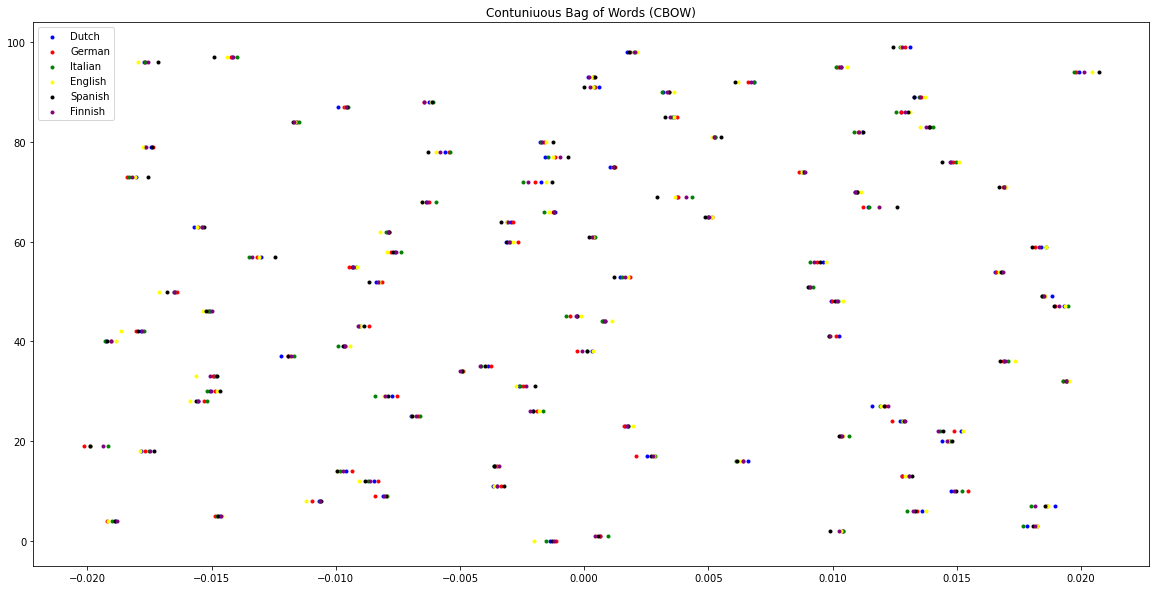

In [222]:
def plot(model, color = 'blue'):
    plt.scatter(model[:100], np.arange(0,100), marker=".",c= color)
plt.figure(figsize=(20,10))
plt.title('Contuniuous Bag of Words (CBOW)')
#plotting functions against their indexes
plot(flat_cbow_Dutch, color = 'blue')
plot(flat_cbow_German, color = 'red')
plot(flat_cbow_Italian, color = 'green')
plot(flat_cbow_English, color = 'yellow')
plot(flat_cbow_Spanish, color = 'black')
plot(flat_cbow_Finnish, color = 'purple')

plt.legend(names)
plt.show()

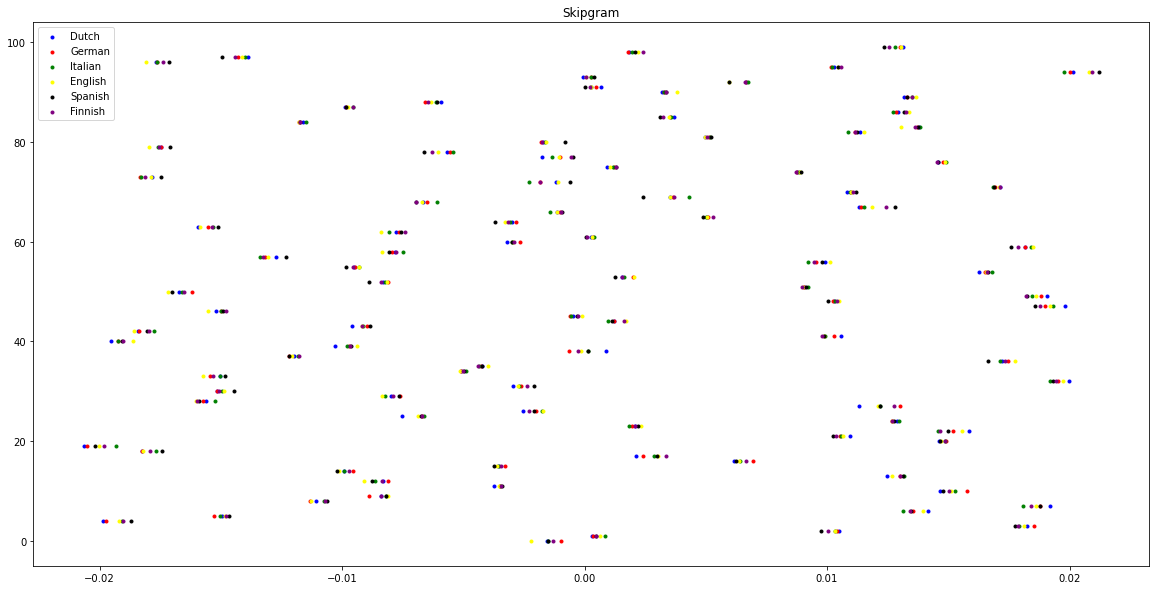

In [223]:
plt.figure(figsize=(20,10))
plt.title('Skipgram')
plot(flat_skipgram_Dutch, color = 'blue')
plot(flat_skipgram_German, color = 'red')
plot(flat_skipgram_Italian, color = 'green')
plot(flat_skipgram_English, color = 'yellow')
plot(flat_skipgram_Spanish, color = 'black')
plot(flat_skipgram_Finnish, color = 'purple')
plt.legend(names)
plt.show()

In [224]:
from sklearn.metrics.pairwise import cosine_similarity
for_sim = pd.DataFrame([flat_skipgram_Dutch, flat_skipgram_German, flat_skipgram_Italian, flat_skipgram_English, flat_skipgram_Spanish, flat_skipgram_Finnish][:100])
for_sim.index = names
for_sim.dropna(axis = 1,inplace=True)

In [225]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(for_sim)
pd.DataFrame(sim)

,0,1,2,3,4,5
0,1.000000,0.999579,0.999682,0.999667,0.998982,0.999437
1,0.999579,1.000001,0.999664,0.999612,0.999132,0.999659
2,0.999682,0.999664,0.999999,0.999716,0.998909,0.999600
3,0.999667,0.999612,0.999716,1.000000,0.999042,0.999578
4,0.998982,0.999132,0.998909,0.999042,1.000000,0.999447
5,0.999437,0.999659,0.999600,0.999578,0.999447,1.000000


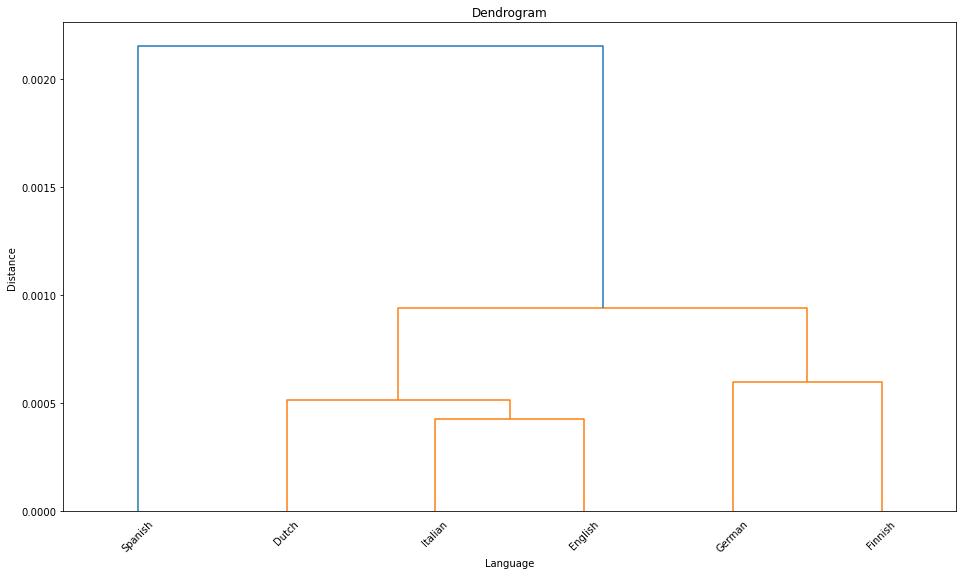

In [226]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(sim, 'ward')
plt.figure(figsize=(16, 9))
labels = for_sim.columns
dendrogram(Z, leaf_rotation=90, leaf_font_size=7., labels = names)
plt.title('Dendrogram')
plt.ylabel('Distance')
plt.xlabel('Language')
plt.xticks(rotation = 45, fontsize = 10)

plt.show()

In [227]:
for_sim_cbow = pd.DataFrame([flat_cbow_Dutch, flat_cbow_German, flat_cbow_Italian, flat_cbow_English, flat_cbow_Spanish, flat_cbow_Finnish][:100])
for_sim_cbow.index = names
for_sim_cbow.dropna(axis = 1, inplace = True)


In [228]:
sim_cbow = cosine_similarity(for_sim_cbow)
pd.DataFrame(sim_cbow)


,0,1,2,3,4,5
0,1.000000,0.999814,0.999843,0.999823,0.999482,0.999820
1,0.999814,1.000000,0.999792,0.999782,0.999475,0.999826
2,0.999843,0.999792,0.999999,0.999818,0.999341,0.999863
3,0.999823,0.999782,0.999818,1.000000,0.999460,0.999824
4,0.999482,0.999475,0.999341,0.999460,1.000000,0.999600
5,0.999820,0.999826,0.999863,0.999824,0.999600,1.000000


(array([ 5, 15, 25, 35, 45, 55]),
 [Text(5, 0, 'Spanish'),
  Text(15, 0, 'Italian'),
  Text(25, 0, 'Dutch'),
  Text(35, 0, 'English'),
  Text(45, 0, 'German'),
  Text(55, 0, 'Finnish')])

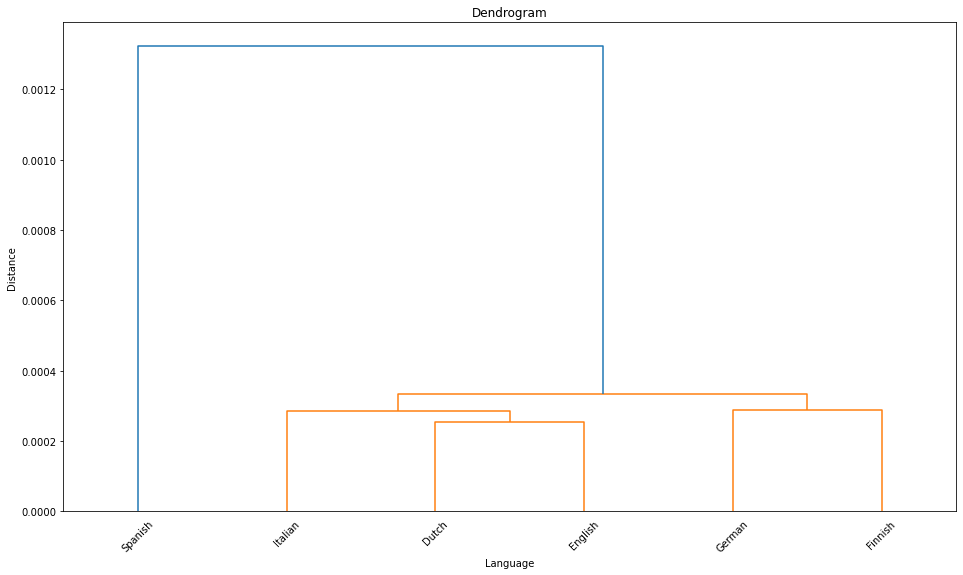

In [229]:
Z_cbow = linkage(sim_cbow, 'ward')
plt.figure(figsize=(16, 9))
labels = for_sim_cbow.columns
dendrogram(Z_cbow, leaf_rotation=90, leaf_font_size=7., labels = names)
plt.title('Dendrogram')
plt.ylabel('Distance')
plt.xlabel('Language')
plt.xticks(rotation = 45, fontsize = 10)
